##  1. Общее описание

**Аналитическая задача** — провести анализ данных с целью выделения портрета клиентов, которые будут открывать карту, и портрета клиентов, которые не будут открывать карту.

## Описание данных
Каждый клиент описывается следующим набором признаков:

|Признак|Комментарий|
|--:|:--|
|`client_id`|Идентификационный номер|
|`gender`|Пол|
|`age`|Возраст|
|`marital_status`|Семейный статус|
|`job_position`|Работа|
|`credit_sum`|Сумма кредита|
|`credit_month`|Срок кредитования|
|`score_shk`|Внутренняя скоринговая оценка|
|`education`|Образование|
|`tariff_id`|Идентификационный номер тарифа|
|`living_region`|Регион|
|`monthly_income`|Месячный заработок|
|`credit_count`|Количество кредитов у клиента|
|`overdue_credit_count`|Количество просроченных кредитов у клиента|
|`open_account_flg`|Факт открытия кредитного счета в данном банке|
|`avregzarplata`|Средняя заработная плата в регионе|
|`okrug`|Федеральный округ|
|date_bank|Дата обращения в банк|

## Примерный план по выполнению проекта

**Шаг 1.** Загрузка данных;

**Шаг 2.** Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

**Шаг 3.** Провести исследовательский анализ данных:
- исследовать распределения признаков;
- исследовать возможные зависимости между признаками;

**Шаг 4.** Отбор признаков и портреты клиентов:
- исследовать признаки в разрезе групп;
- выявить наличие значимых различий в значениям признаков в разрезе групп;
- сформулировать и проверить гипотезы о равенстве значений показателей по группам

**Шаг 5.** Построить классификационные модели 
- Построить несколько моделей классификации и сравнить их.    
- исследовать возможные зависимости между признаками;


Дополнительное задание (выполнение по желанию):  построить классификационные модели для прогнозирования значений целевой переменной. 

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import datetime as dt

In [80]:
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import anderson
from scipy.stats import jarque_bera

In [81]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal

from scipy import stats

In [82]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

#загрузка классификаторов
from sklearn.tree import DecisionTreeClassifier, plot_tree # дерево решений
from sklearn.ensemble import RandomForestClassifier #случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регресси
from sklearn.svm import SVC # метод опорных векторов
from sklearn.linear_model import SGDClassifier # стохастический градиентный спуск

#метрики
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

**Шаг 1.** Загрузка данных;


In [83]:
df = pd.read_csv('/Users/elmypka/Downloads/project_1_4/project_4/vkr_dataset_open_credit_card.csv')

##### Фунции, необходимые для дальнейшей работы

In [84]:
"""""
Функция выводит информационный текст - 
отсотированный список столбцов, в которых имеются пропуски
"""""

def search_nan(data, parametr=''):   
    if parametr == '':
        series_null_list =[]
        series_null = data.isnull().sum().sort_values(ascending=False)
        for i in series_null.index:
            if series_null[i] > 0:
                print('В столбце -', i, '- пропущено:', series_null[i], ';')
                series_null_list.append(i)
        print()
    elif parametr != '':
        if data[parametr].isnull().sum() > 0:
            print('В столбце -', parametr, '- пропущено:', data[parametr].isnull().sum(), ';')
        else:
            print('нет пропусков')
    #return series_null_list
    print()

In [85]:
"""
Функция для расчета значений нижнего и верхнего усов.
На вход подается столбец датафрейма,
на выходе кортеж: первый элемент -- нижний ус, второй элемент -- верхний ус
"""

def calc_boxplot(df_col : pd.Series) -> tuple:
    Q1, median, Q3 = np.percentile(np.asarray(df_col.dropna()), [25, 50, 75])
    IQR = Q3 - Q1
    loval = Q1 - 1.5 * IQR
    hival = Q3 + 1.5 * IQR
    wiskhi = np.compress(np.asarray(df_col.dropna()) <= hival, np.asarray(df_col.dropna()))
    wisklo = np.compress(np.asarray(df_col.dropna()) >= loval, np.asarray(df_col.dropna()))
    actual_hival = np.max(wiskhi)
    actual_loval = np.min(wisklo)
    return actual_loval, actual_hival #(нижний ус, верхний ус)

In [86]:
"""
Функция для проверки подчинения одному и тому же распределению по Колмогорова-Смирнова
"""

def ks_test(df):
    import pandas as pd
    from scipy import stats
    for col in df.columns:
        if 1 in df['overdue_credit_count'].unique() and 0 in df['overdue_credit_count'].unique():
            data_1 = df[df['overdue_credit_count'] == 1][col]
            data_0 = df[df['overdue_credit_count'] == 0][col]
            ks_statistic, p_value = stats.ks_2samp(data_1, data_0)
            print(f"Kolmogorov-Smirnov test for column {col}: KS Statistic = {ks_statistic}, p-value = {p_value}")
            if p_value > 0.05:
                print("H_0: Обе выборки подчиняются из одному и тому же распределению.")
                print('------------------------------------------------------------')

            else:
                print("H_1: Обе выборки происходят из разных распределений.")
                print('------------------------------------------------------------')




In [87]:

"""
Функция для проверки различий в распределении частот по U-критерию Манна — Уитни
"""
def mann_whitney_test(df):
    for col in df.columns:
        if 1 in df['overdue_credit_count'].unique() and 0 in df['overdue_credit_count'].unique():
            data_1 = df[df['overdue_credit_count'] == 1][col]
            data_0 = df[df['overdue_credit_count'] == 0][col]
            u_statistic, p_value = stats.mannwhitneyu(data_1, data_0)
            print(f"Mann-Whitney U test for column {col}: U Statistic = {u_statistic}, p-value = {p_value}")
            if p_value > 0.05:
                print(f"Нулевая гипотеза (отсутствует различие в распределении частот) не может быть отклонена.\
                       H_0 - Разница в признаке {col} статистически не значима.")  
                print(f'Среднее значение признака {col}: 1 - у людей с картой {data_1.mean()} ||| 2 - у людей без карты {data_0.mean()}')

                print('------------------------------------------------------------')
            else:
                print(f"Нулевая гипотеза (отсутствует различие в распределении частот) отклонена.\
                      H_1 - Разница в признаке {col} статистически значима.")
                print(f'Среднее значение признака {col}: 1 - у людей с картой {data_1.mean()} ||| 2 - у людей без карты {data_0.mean()}')

                print('------------------------------------------------------------')
                

## Первичная обработка данных
________________

**Шаг 2.** Первичная обработка данных (при необходимости):
- скорректировать заголовки;
- скорректировать типы признаков;
- проверить наличие дублирующихся записей;
- проверить наличие аномальных значений;
- восстановить пропущенные значения;

- Знакомимся с таблицей


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170746 entries, 0 to 170745
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170746 non-null  int64  
 1   gender                170746 non-null  int64  
 2   age                   170744 non-null  float64
 3   marital_status        170741 non-null  float64
 4   job_position          170746 non-null  int64  
 5   credit_sum            170745 non-null  object 
 6   credit_month          170746 non-null  int64  
 7   score_shk             170743 non-null  object 
 8   education             170743 non-null  float64
 9   tariff_id             170746 non-null  int64  
 10  living_region         170554 non-null  float64
 11  okrug                 170554 non-null  float64
 12  avregzarplata         170554 non-null  float64
 13  monthly_income        170744 non-null  float64
 14  credit_count          161516 non-null  float64
 15  

## Корректировка заголовков

In [89]:
df.rename(columns = {'client_id': 'user_id',
                     'avregzarplata':'avg_zarplata'
                     }, inplace = True)

## Корректировка типов данных

Меняем:

 score_shk на float


credit_sum на float


date_bank на datetime64


In [90]:
df['score_shk'] = df['score_shk'].apply(lambda x: str(x).replace(",", ".")).astype('float')
df['credit_sum'] = df['credit_sum'].apply(lambda x: str(x).replace(",", ".")).astype('float')
df['date_bank'] = df['date_bank'].astype('datetime64[ns]')



Удаляем 2 пропуска в age, чтобы поменять на int


In [91]:
df = df.dropna(subset=['age'])

Меняем age на int


In [92]:

df['age'] = df['age'].astype('int')


## Проверка дубликатов

Поиск дубликатов

Поиск дубликатов без столбца user_id


In [93]:
df.duplicated().sum()

df.drop(columns='user_id').duplicated().sum()

0

## Поиск и устранение аномалий

В marital_status и education много пропусков, поэтому меняем на Int64. 

Этот тип данных разрешает работать с пропусками для поиска аномалий


In [94]:
df['marital_status'] = df['marital_status'].astype('Int64')
df['education'] = df['education'].astype('Int64')

Добавляем столбец с годами и месяцами для более детального анализа

In [95]:
df['year'] = df.date_bank.dt.year
df['month'] = df.date_bank.dt.month

Проверяем таблицу

In [96]:
df.head(2)

user_id  gender  age  marital_status  job_position  credit_sum  \
0        1       2   48               3            15     59998.0   
1        2       1   28            <NA>            15     10889.0   

   credit_month  score_shk  education  tariff_id  living_region  okrug  \
0            10   0.770249          2         28           23.0    8.0   
1             6   0.248514          2          2           30.0    7.0   

   avg_zarplata  monthly_income  credit_count  overdue_credit_count  \
0       25850.0         30000.0           1.0                   1.0   
1       66880.0         43000.0           2.0                   0.0   

   open_account_flg           date_bank  year  month  
0                 0 2016-02-16 18:54:34  2016      2  
1                 0 2016-02-15 12:39:04  2016      2

Создаем переменные с категориальными и непрерывными признаками


In [97]:
cat_vars = 'age', 'gender', 'marital_status', 'job_position', 'credit_month',\
    'education', 'tariff_id', 'living_region', 'okrug', 'credit_count',\
    'overdue_credit_count', 'open_account_flg', 'year', 'month'
nepr_vars = 'credit_sum','score_shk', 'avg_zarplata', 'monthly_income'

Создаем словарь для более красивого вывода в визуализации


In [98]:
dict_to_rus = {'user_id': 'Идентификационный номер|',
              'gender': 'Пол', 
              'age' : 'Возраст', 
              'marital_status' : 'Семейный статус',
              'job_position' : 'Работа',
              'credit_sum': 'Сумма кредита', 
              'credit_month' : 'Срок кредитования', 
              'score_shk' : 'Внутренняя скоринговая оценка', 
              'education' : 'Образование', 
              'tariff_id' : 'Идентификационный номер тарифа',
              'living_region' : 'Регион', 
              'okrug' : 'Федеральный округ', 
              'avg_zarplata' : 'Средняя заработная плата в регионе', 
              'monthly_income' : 'Месячный заработок',
              'credit_count' : 'Количество кредитов у клиента', 
              'overdue_credit_count' : 'Количество просроченных кредитов у клиента', 
              'open_account_flg' : 'Факт открытия кредитного счета в данном банке', 
              'date_bank': 'Дата обращения в банк',
              'year' : 'Год обращения в банк',
              'month': 'Месяц обращения в банк',
}

Переменная с перцентилями


In [99]:
per =[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

Смотрим перцентили и ищем аномалии




In [100]:
df.describe(per)

user_id         gender            age  marital_status  \
count  170744.000000  170744.000000  170744.000000        170739.0   
mean    85374.499883       1.480526      36.497312        3.197588   
min         1.000000       1.000000      18.000000             1.0   
1%       1710.430000       1.000000      21.000000             1.0   
5%       8540.150000       1.000000      23.000000             2.0   
25%     42688.750000       1.000000      28.000000             3.0   
50%     85374.500000       1.000000      34.000000             3.0   
75%    128060.250000       2.000000      43.000000             4.0   
95%    162208.850000       2.000000      57.000000             4.0   
99%    169038.570000       2.000000      65.000000             5.0   
max    170746.000000       2.000000      71.000000             5.0   
std     49289.691721       0.499622      10.546067        0.738574   

        job_position     credit_sum   credit_month      score_shk  education  \
count  170744.000000  170743.000000  170744.000000  170741.000000   170741.0   
mean       13.160006   26095.270158      10.980784       0.469472   3.202705   
min         1.000000    2736.000000       3.000000       0.000000        1.0   
1%          1.000000    4989.000000       4.000000       0.210355        2.0   
5%          4.000000    8059.000000       6.000000       0.278508        2.0   
25%        14.000000   14908.000000      10.000000       0.379495        2.0   
50%        14.000000   21229.000000      10.000000       0.461599        4.0   
75%        14.000000   32068.000000      12.000000       0.552427        4.0   
95%        15.000000   59847.200000      18.000000       0.691609        5.0   
99%        15.000000   75315.042000      24.000000       0.756609        5.0   
max        18.000000  200000.000000      36.000000       1.128291        5.0   
std         3.132438   16234.846480       3.536697       0.124268   1.064028   

           tariff_id  living_region          okrug   avg_zarplata  \
count  170744.000000  170552.000000  170552.000000  170552.000000   
mean       14.118839      43.010085       4.817135   32957.772058   
min         1.000000       1.000000       1.000000   16830.000000   
1%          1.000000       3.000000       1.000000   17490.000000   
5%          2.000000       7.000000       2.000000   20130.000000   
25%         2.000000      25.000000       2.000000   25520.000000   
50%        19.000000      40.000000       5.000000   27390.000000   
75%        28.000000      63.000000       7.000000   42460.000000   
95%        28.000000      76.000000       8.000000   66880.000000   
99%        30.000000      80.000000       8.000000   66880.000000   
max        33.000000      82.000000       8.000000   66880.000000   
std        11.546768      22.219876       2.263187   12577.506049   

       monthly_income   credit_count  overdue_credit_count  open_account_flg  \
count   170742.000000  161514.000000         161514.000000     170744.000000   
mean     40138.484058       2.107303              0.046070          0.176030   
min       5000.000000       0.000000              0.000000          0.000000   
1%       11000.000000       0.000000              0.000000          0.000000   
5%       15000.000000       0.000000              0.000000          0.000000   
25%      25000.000000       1.000000              0.000000          0.000000   
50%      35000.000000       2.000000              0.000000          0.000000   
75%      50000.000000       3.000000              0.000000          0.000000   
95%      80000.000000       5.000000              0.000000          1.000000   
99%     120000.000000       8.000000              1.000000          1.000000   
max     950000.000000      21.000000              3.000000          1.000000   
std      25044.376923       1.777138              0.211549          0.380846   

                           date_bank           year          month  
count                         170744  170744.000000  

**Чистка аномалий**

Убираем аномальный **возраст**


Проверяем какой процент записей удаляется после чистки аномалий

Проверяем сколько записей остается после чистки аномалий


In [101]:
no_anomals_age = df.age.between(18,65)
(1 - df[no_anomals_age].shape[0] / df.shape[0]) * 100
print(f'Очистка аномалий удаляет {(1 - df[no_anomals_age].shape[0] / df.shape[0]) * 100 :.2f}% данных')
print(f'После очистки аномалий остается {df[no_anomals_age].shape[0]} записей из {df.shape[0]}')

Очистка аномалий удаляет 0.77% данных
После очистки аномалий остается 169422 записей из 170744


Ящик с усами для признака возраст

Text(0, 0.5, 'Возраст, лет')

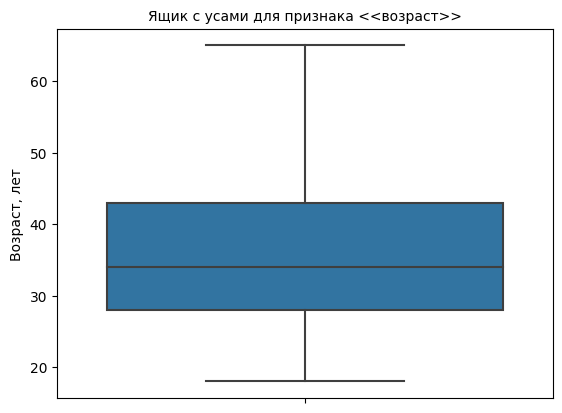

In [102]:
sns.boxplot(data=df,
            y=df[no_anomals_age].age)
plt.title('Ящик с усами для признака <<возраст>>', fontsize=10)
plt.ylabel('Возраст, лет', fontsize=10)

Убираем аномальные **суммы кредита**

 и аномальный возраст. 

Смотрим количество потерянных данных в процентах

Проверяем сколько записей остается после чистки аномалий


In [103]:
no_anomals_credit_sum = df.loc[no_anomals_age].credit_sum.between(4900, 60000)
print(f'Очистка аномалий удаляет {(1 - df[no_anomals_age & no_anomals_credit_sum].shape[0] / df.shape[0]) * 100 :.2f}% данных')
print(f'После очистки аномалий остается {df[no_anomals_age & no_anomals_credit_sum].shape[0]} записей из {df.shape[0]}')

Очистка аномалий удаляет 6.48% данных
После очистки аномалий остается 159678 записей из 170744


Ящик с усами для признака сумма кредита


Text(0, 0.5, 'Сумма')

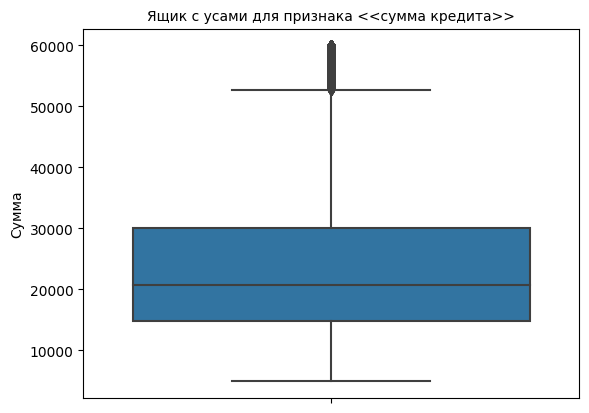

In [104]:
sns.boxplot(data=df,
            y=df[no_anomals_age & no_anomals_credit_sum].credit_sum)
plt.title('Ящик с усами для признака <<сумма кредита>>', fontsize=10)
plt.ylabel('Сумма', fontsize=10)

Убираем аномальные **месячные заработки**,


суммы кредита и аномальный возраст

Проверяем какой процент записей удаляется после чистки аномалий

Проверяем сколько записей остается после чистки аномалий




In [105]:
no_anomals_monthly_income= df.loc[no_anomals_age & no_anomals_credit_sum].monthly_income.between(5000, 85000)
print(f'Очистка аномалий удаляет {(1 - df[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income].shape[0] / df.shape[0]) * 100 :.2f}% данных')
print(f'После очистки аномалий остается {df[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income].shape[0]} записей из {df.shape[0]}')

Очистка аномалий удаляет 9.67% данных
После очистки аномалий остается 154229 записей из 170744


Ящик с усами для признака месячный заработок


Text(0, 0.5, 'Сумма')

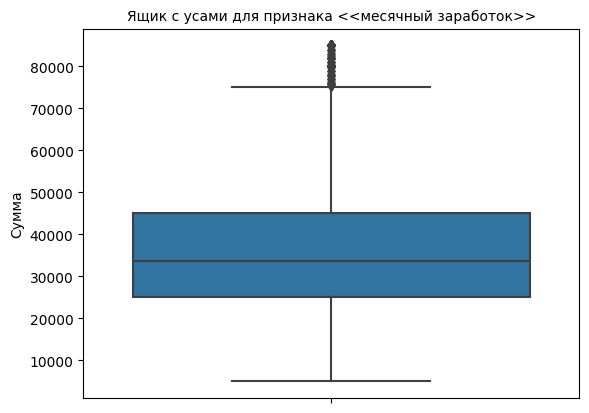

In [106]:
sns.boxplot(data=df,
            y=df[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income].monthly_income)
plt.title('Ящик с усами для признака <<месячный заработок>>', fontsize=10)
plt.ylabel('Сумма', fontsize=10)

 Призанак **cредняя заработная плата в регионе** очищать не будем. Выходят большие потери данных 




Text(0, 0.5, 'Сумма')

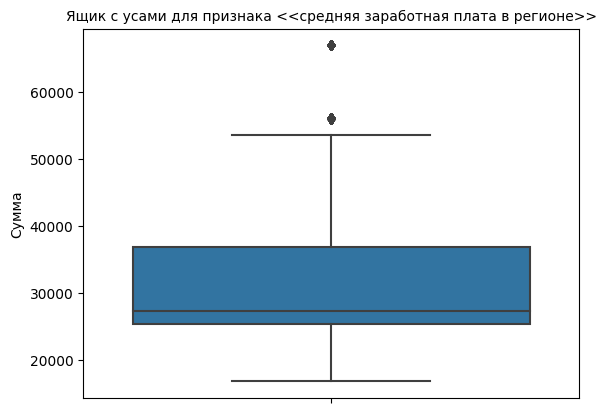

In [107]:
sns.boxplot(data=df,
            y=df[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income].avg_zarplata)
plt.title('Ящик с усами для признака <<средняя заработная плата в регионе>>', fontsize=10)
plt.ylabel('Сумма', fontsize=10)

Cмотрим еще раз аномалии уже в почищенных данных
Думаю, что можно уже остановиться

In [108]:
df.loc[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income].describe(per)

user_id         gender            age  marital_status  \
count  154229.000000  154229.000000  154229.000000        154225.0   
mean    85450.880450       1.473303      36.241621        3.197024   
min         1.000000       1.000000      18.000000             1.0   
1%       1701.280000       1.000000      21.000000             1.0   
5%       8522.400000       1.000000      23.000000             2.0   
25%     42761.000000       1.000000      28.000000             3.0   
50%     85527.000000       1.000000      34.000000             3.0   
75%    128156.000000       2.000000      43.000000             4.0   
95%    162214.200000       2.000000      56.000000             4.0   
99%    169063.720000       2.000000      63.000000             5.0   
max    170746.000000       2.000000      65.000000             5.0   
std     49307.313285       0.499288      10.283675        0.738764   

        job_position     credit_sum   credit_month      score_shk  education  \
count  154229.000000  154229.000000  154229.000000  154226.000000   154226.0   
mean       13.265612   23724.130524      10.955313       0.471082   3.241898   
min         1.000000    4900.000000       3.000000       0.000000        1.0   
1%          1.000000    5859.280000       4.000000       0.214463        2.0   
5%          4.000000    8439.000000       6.000000       0.281897        2.0   
25%        14.000000   14668.000000      10.000000       0.381262        2.0   
50%        14.000000   20418.000000      10.000000       0.463038        4.0   
75%        14.000000   29469.000000      12.000000       0.553771        4.0   
95%        15.000000   50835.000000      18.000000       0.691740        5.0   
99%        15.000000   57988.720000      24.000000       0.756165        5.0   
max        18.000000   60000.000000      36.000000       1.128291        5.0   
std         2.974222   12590.052212       3.400145       0.123550   1.055535   

           tariff_id  living_region          okrug   avg_zarplata  \
count  154229.000000  154060.000000  154060.000000  154060.000000   
mean       14.160126      43.077541       4.796534   32302.848046   
min         1.000000       1.000000       1.000000   16830.000000   
1%          1.000000       3.000000       1.000000   17490.000000   
5%          2.000000       7.000000       2.000000   20020.000000   
25%         2.000000      25.000000       2.000000   25300.000000   
50%        19.000000      40.000000       5.000000   27280.000000   
75%        28.000000      63.000000       7.000000   36850.000000   
95%        28.000000      76.000000       8.000000   56000.000000   
99%        30.000000      80.000000       8.000000   66880.000000   
max        33.000000      82.000000       8.000000   66880.000000   
std        11.507157      22.372407       2.260411   12079.090073   

       monthly_income   credit_count  overdue_credit_count  open_account_flg  \
count   154229.000000  145779.000000         145779.000000     154229.000000   
mean     36271.460990       2.078969              0.045706          0.176679   
min       5000.000000       0.000000              0.000000          0.000000   
1%       11000.000000       0.000000              0.000000          0.000000   
5%       15000.000000       0.000000              0.000000          0.000000   
25%      25000.000000       1.000000              0.000000          0.000000   
50%      33600.000000       2.000000              0.000000          0.000000   
75%      45000.000000       3.000000              0.000000          0.000000   
95%      70000.000000       5.000000              0.000000          1.000000   
99%      80000.000000       8.000000              1.000000          1.000000   
max      85000.000000      19.000000              3.000000          1.000000   
std      15779.100789       1.754959              0.210777          0.381398   

                           date_bank           year          month  
count                         154229  154229.000000  

После очистки данных у нас удалилось 9.67% данных, осталось 154229 записей из 170744

In [109]:
#Перезаписываем df

df = df.loc[no_anomals_age & no_anomals_credit_sum & no_anomals_monthly_income]

### Работа с пропусками
___

Проверям с помощью функции пропуски 


In [110]:
search_nan(df)

В столбце - overdue_credit_count - пропущено: 8450 ;
В столбце - credit_count - пропущено: 8450 ;
В столбце - living_region - пропущено: 169 ;
В столбце - avg_zarplata - пропущено: 169 ;
В столбце - okrug - пропущено: 169 ;
В столбце - marital_status - пропущено: 4 ;
В столбце - score_shk - пропущено: 3 ;
В столбце - education - пропущено: 3 ;




Заполним пропуски медианой

marital_status, score_shk, education удалим

In [114]:
df.loc[df['overdue_credit_count'].isnull(), 'overdue_credit_count'] = df['overdue_credit_count'].median()
df.loc[df['living_region'].isnull(), 'living_region'] = df['living_region'].median()
df.loc[df['okrug'].isnull(), 'okrug'] = df['okrug'].median()
df.loc[df['credit_count'].isnull(), 'credit_count'] = df['credit_count'].median()
df.loc[df['avg_zarplata'].isnull(), 'avg_zarplata'] = df['avg_zarplata'].median()

In [115]:
df.dropna(subset=['marital_status', 'score_shk', 'education'], inplace=True)

Проверяем данные после заполнения. 

Пропусков не осталось

In [116]:
df.isna().sum()

user_id                 0
gender                  0
age                     0
marital_status          0
job_position            0
credit_sum              0
credit_month            0
score_shk               0
education               0
tariff_id               0
living_region           0
okrug                   0
avg_zarplata            0
monthly_income          0
credit_count            0
overdue_credit_count    0
open_account_flg        0
date_bank               0
year                    0
month                   0
dtype: int64

Теперь переведем marital_status и education в обычный int

In [117]:
df['marital_status'] = df['marital_status'].astype('int')
df['education'] = df['education'].astype('int')

### Исследовательский анализ данных


**Шаг 3.** Провести исследовательский анализ данных:
- исследовать распределения признаков;
- исследовать возможные зависимости между признаками;

### Исследовать распределения признаков
___


Сначала посмотрим моду для категориальных признаков


In [118]:
df[['age', 'gender', 'marital_status', 'job_position', 'credit_month',\
    'education', 'tariff_id', 'living_region', 'okrug', 'credit_count',\
    'overdue_credit_count', 'open_account_flg', 'year', 'month']].mode()

age  gender  marital_status  job_position  credit_month  education  \
0   28       1               3            14            10          4   

   tariff_id  living_region  okrug  credit_count  overdue_credit_count  \
0          2           31.0    7.0           2.0                   0.0   

   open_account_flg  year  month  
0                 0  2018      8

Медиана для непрерывных

In [119]:
df[['credit_sum', 'score_shk', 'avg_zarplata', 'monthly_income']].median()

credit_sum        20418.000000
score_shk             0.463038
avg_zarplata      27280.000000
monthly_income    33600.000000
dtype: float64

Создадим сетку точечных диаграмм для сравнения распределения пар 

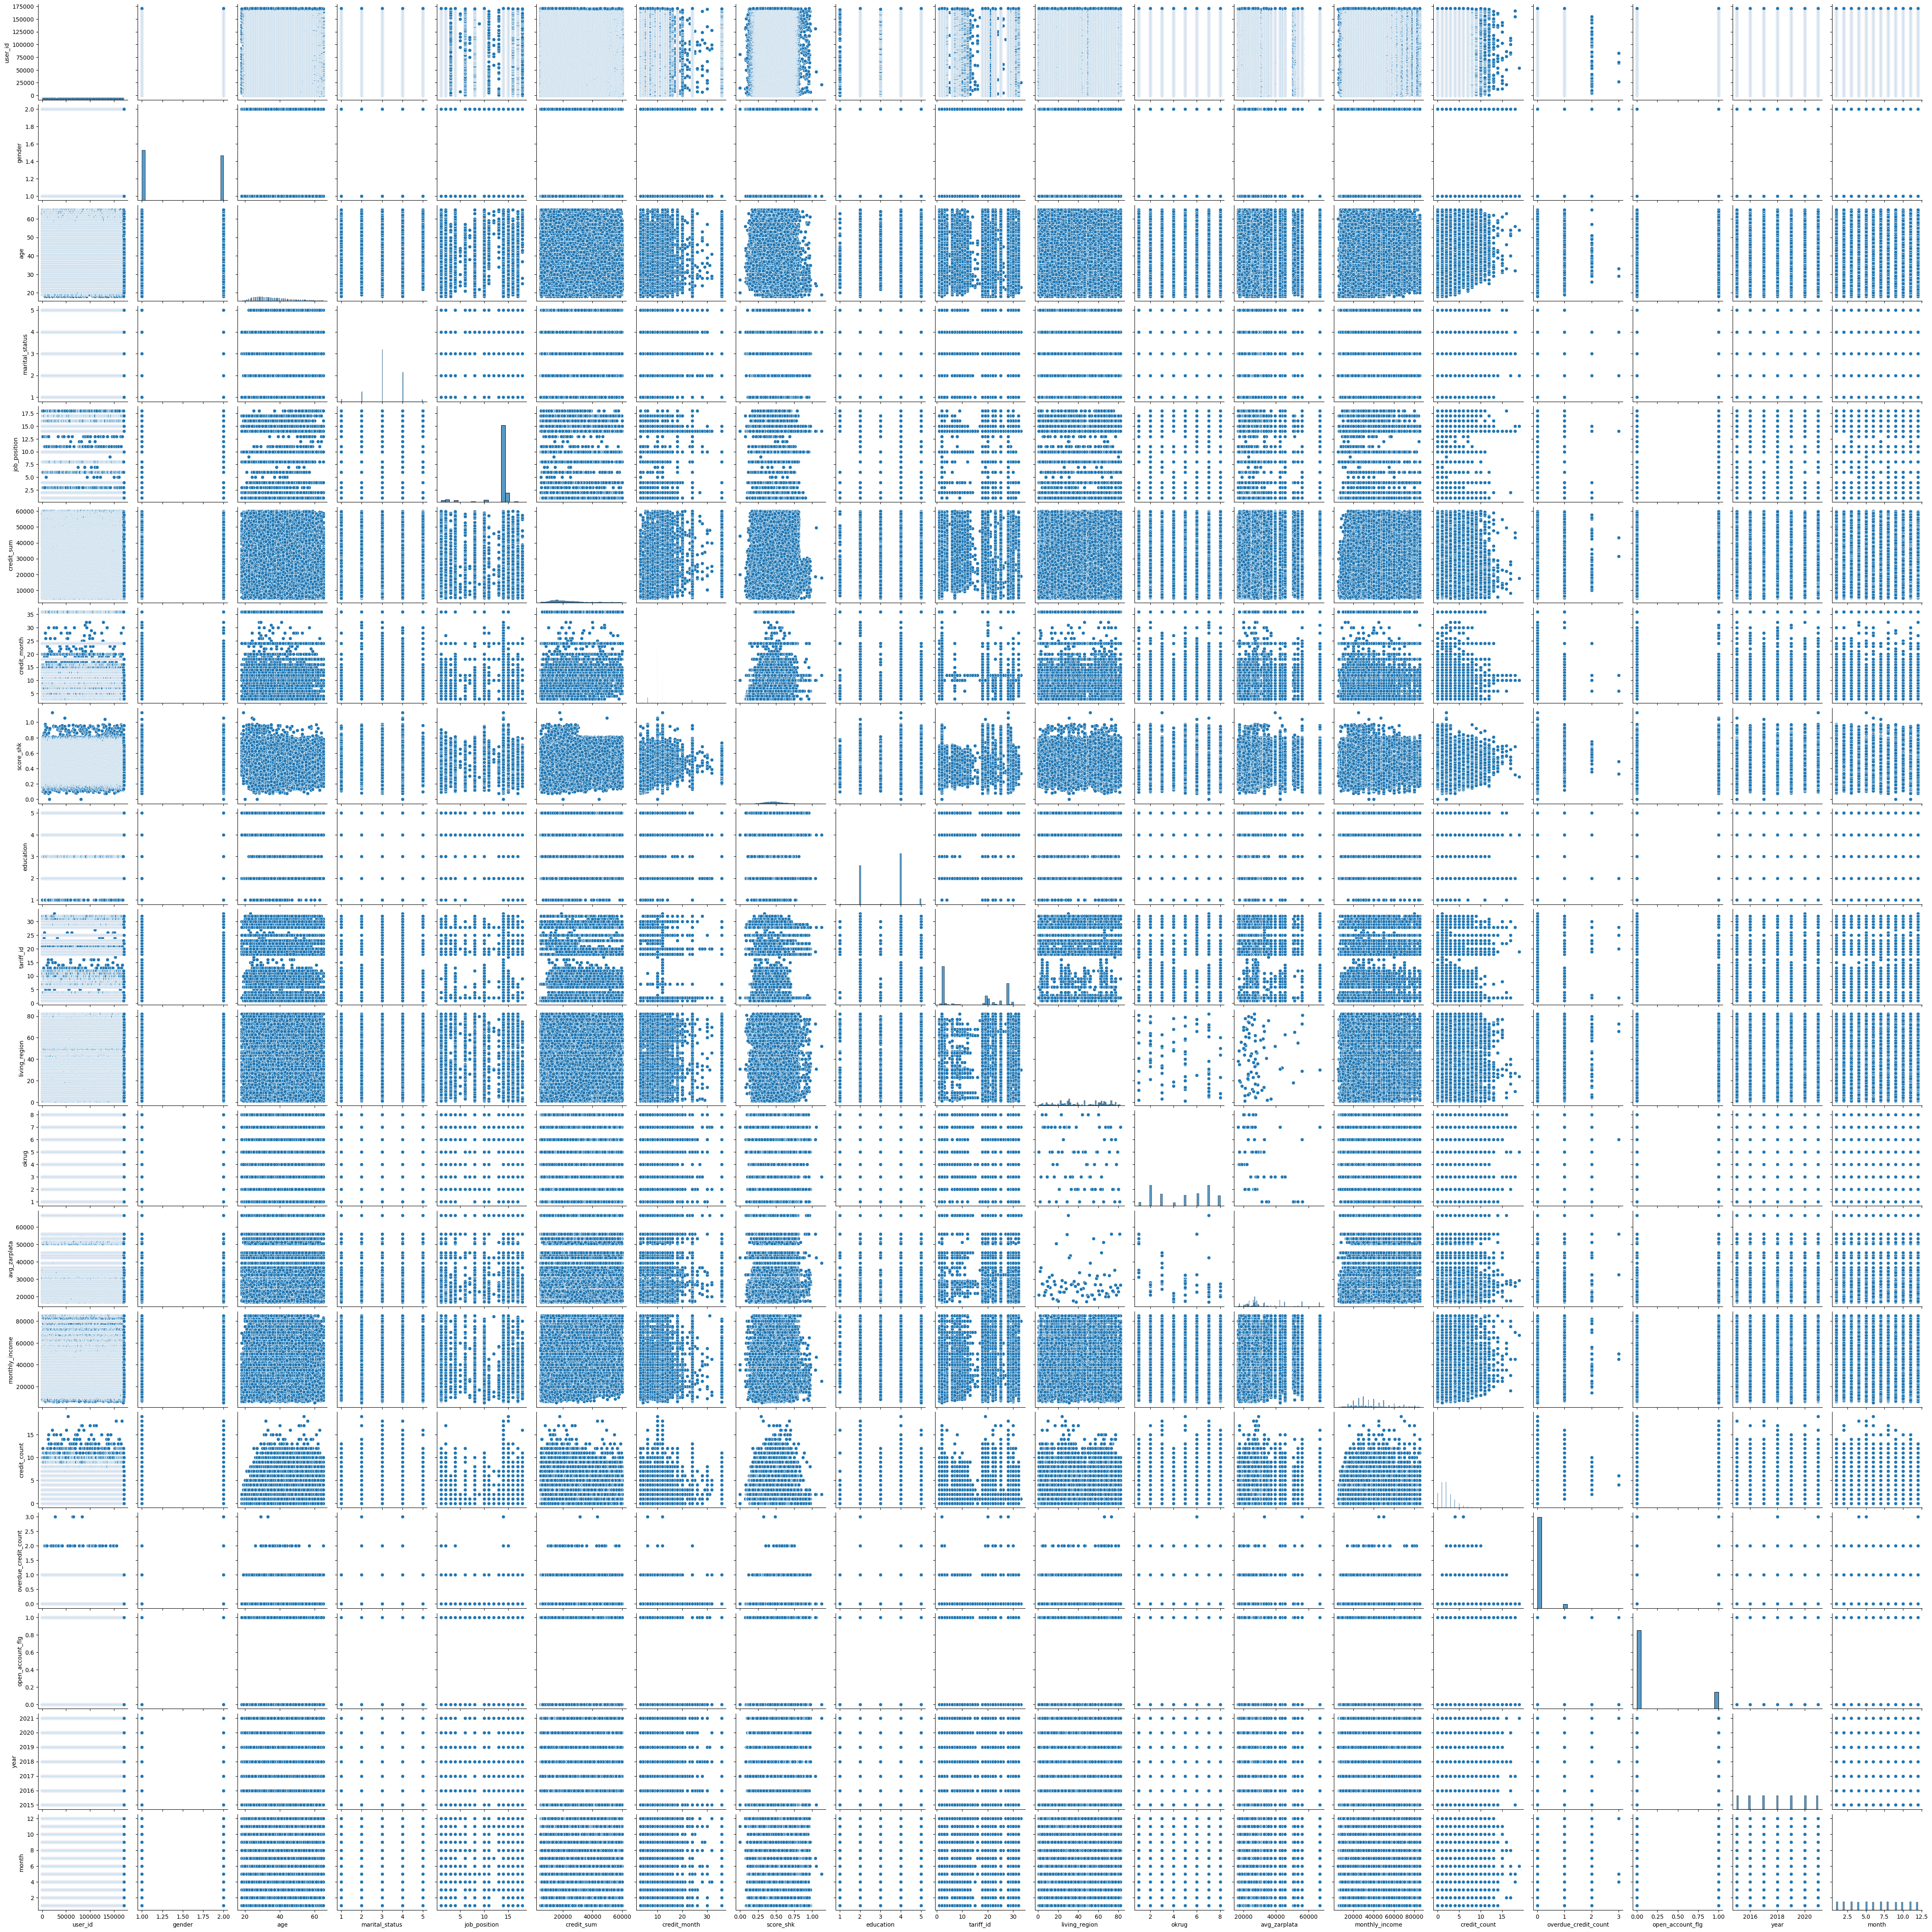

In [120]:
sns.pairplot(data =df)

Никаких четких зависимостей не выявлено

Построим столбчатые диаграммы для категориальных признаков


/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/649352343.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(14, 1 ,i)
/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/649352343.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(14, 1 ,i)


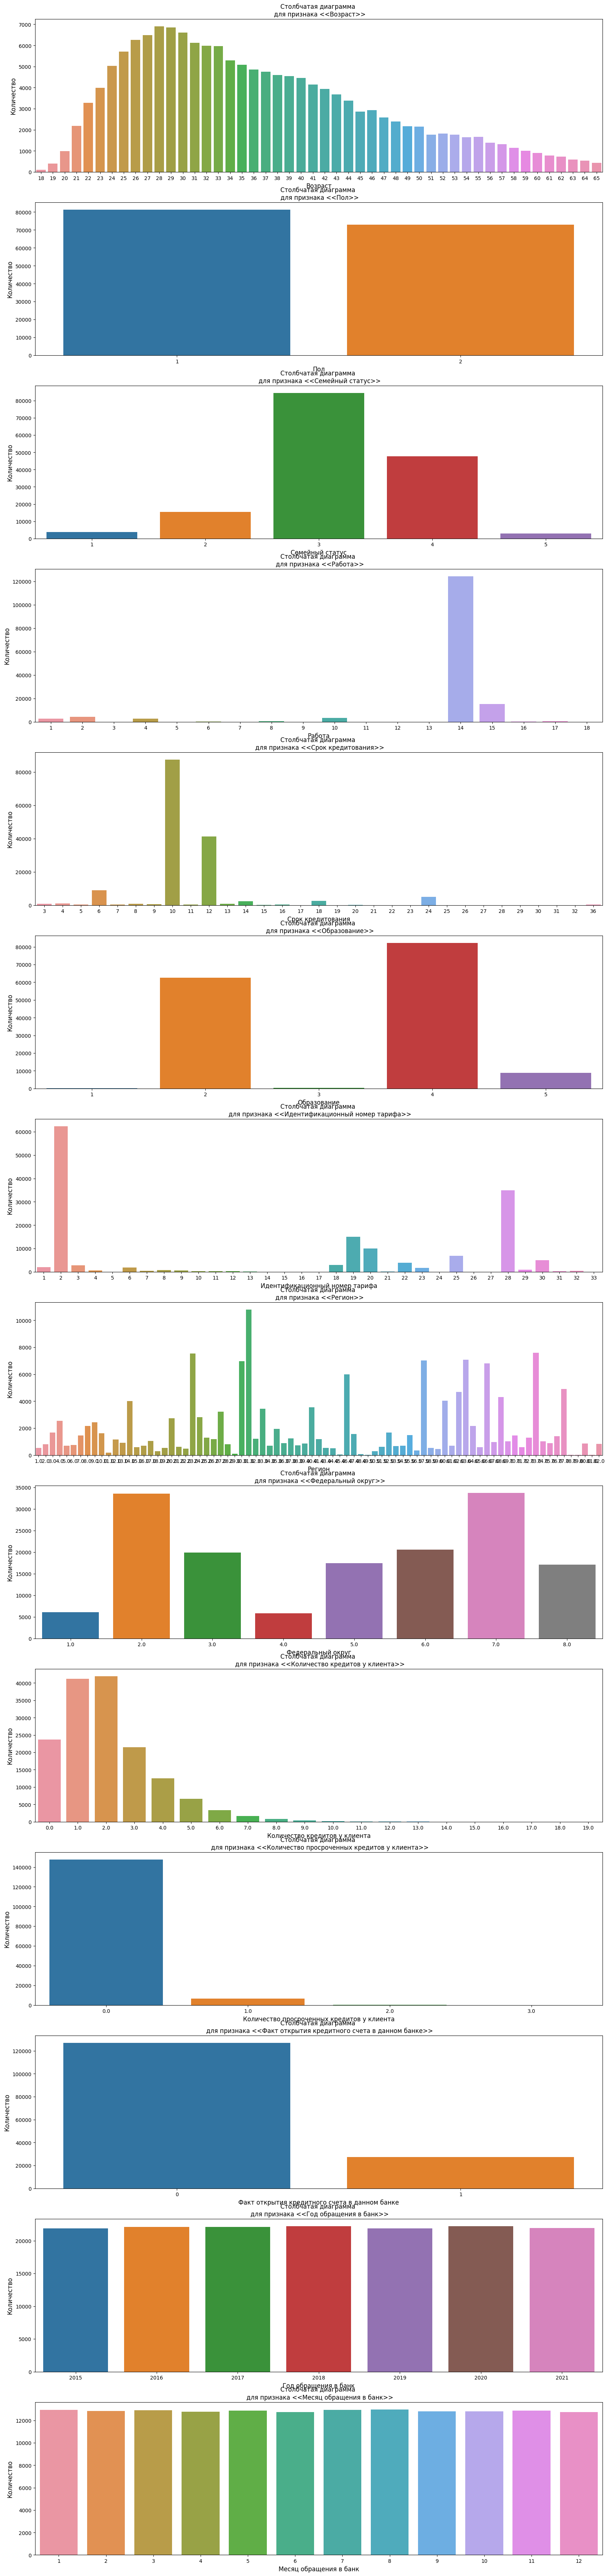

In [121]:
fig, axes = plt.subplots(2, sharey=True, figsize=(20,90))
i=1
for col in cat_vars:
    plt.subplot(14, 1 ,i)
    sns.countplot(x=col, data=df,)
    plt.title("Столбчатая диаграмма \n для признака <<{}>>".format(dict_to_rus[col]))
    plt.xlabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel(dict_to_rus[col], fontsize = 12)
    plt.ylabel('Количество', fontsize = 12)
    i=i+1
  

Выводы по визуализации:
- Пол 1 больше, чем пол 2
-  Семейный статус = 3
-  Работа = 14
-  Образование = 4

Попробуем поискать какие то зависимости.
Построим гистрограмму возраста, группируя данные по полу

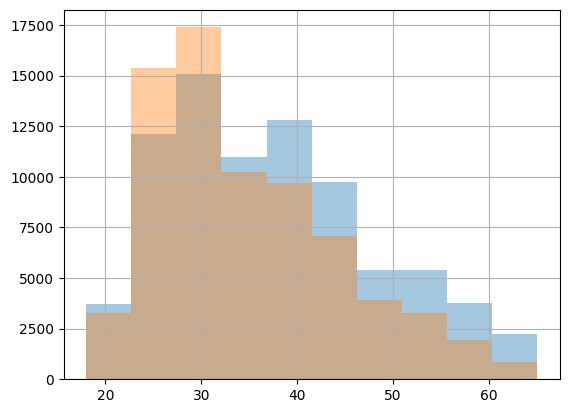

In [122]:
df.groupby('gender').age.hist(alpha=0.4);

Построим гистрограмму возраста, группируя данные по сумме кредита

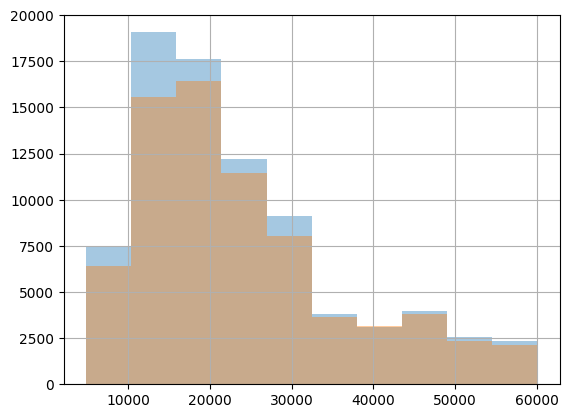

In [123]:
df.groupby('gender').credit_sum.hist(alpha=0.4);

Построим гистрограмму возраста, группируя данные по месячной зарплате

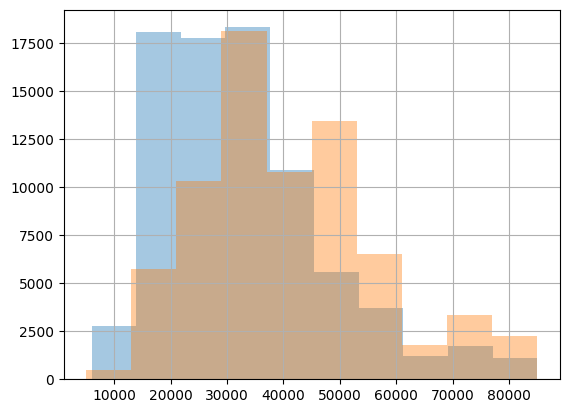

In [124]:
df.groupby('gender').monthly_income.hist(alpha=0.4);


Построим столбчатую диаграмму для образования, группируя по полу

<Axes: xlabel='gender', ylabel='count'>

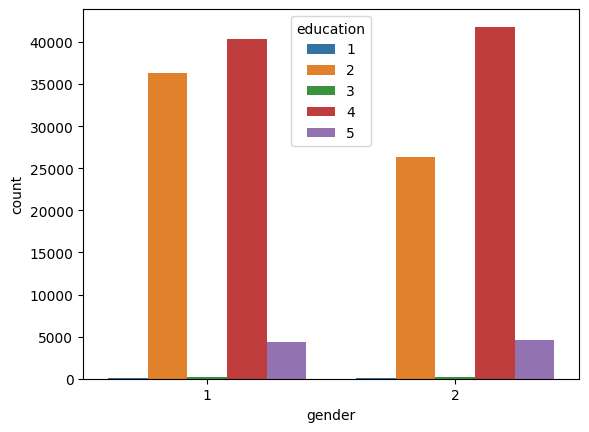

In [125]:
sns.countplot(x = 'gender', hue = 'education', data = df)

Факт открытия кредитного счета в данном банке в зависимости от пола


<Axes: xlabel='gender', ylabel='count'>

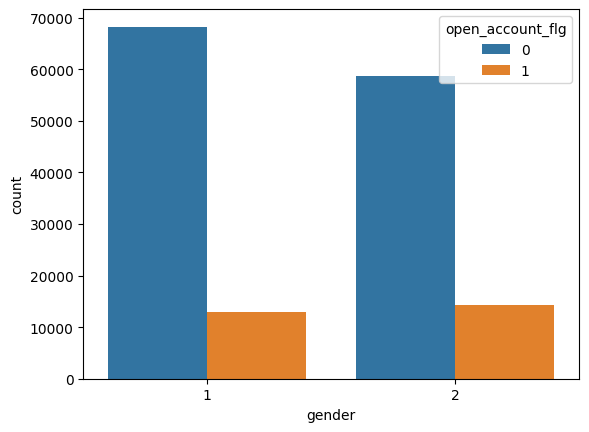

In [126]:
sns.countplot(x = 'gender', hue = 'open_account_flg', data = df)

Посчитаем общее количество кредитов в зависимости от пола


In [127]:
sum_credit_gender = df.groupby('gender')['credit_count'].sum().sort_values(ascending=False)
sum_credit_gender

gender
1    171311.0
2    148637.0
Name: credit_count, dtype: float64

- У клиентов пол == 1 сумма кредитов больше 

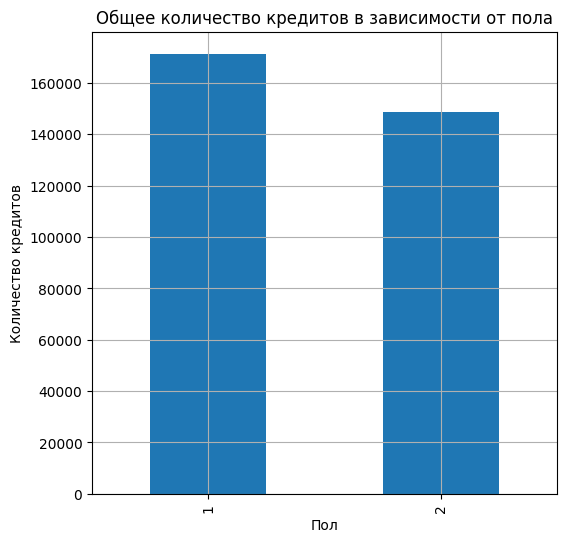

In [128]:
sum_credit_gender.plot(x = 'gender', y = 'credit_count', kind = 'bar',\
figsize=(6,6), grid=True, title = 'Общее количество кредитов в зависимости от пола')
plt.xlabel('Пол')
plt.ylabel('Количество кредитов')
plt.show()

Посчитаем общее количество кредитов в зависимости от региона


In [129]:
sum_credit_region = df.groupby('living_region')['credit_count'].sum().sort_values(ascending=False)
print(sum_credit_region.head(10))

living_region
31.0    20708.0
73.0    17224.0
23.0    15246.0
66.0    14108.0
63.0    13859.0
30.0    13433.0
57.0    13403.0
46.0    12323.0
77.0    10406.0
14.0     9842.0
Name: credit_count, dtype: float64


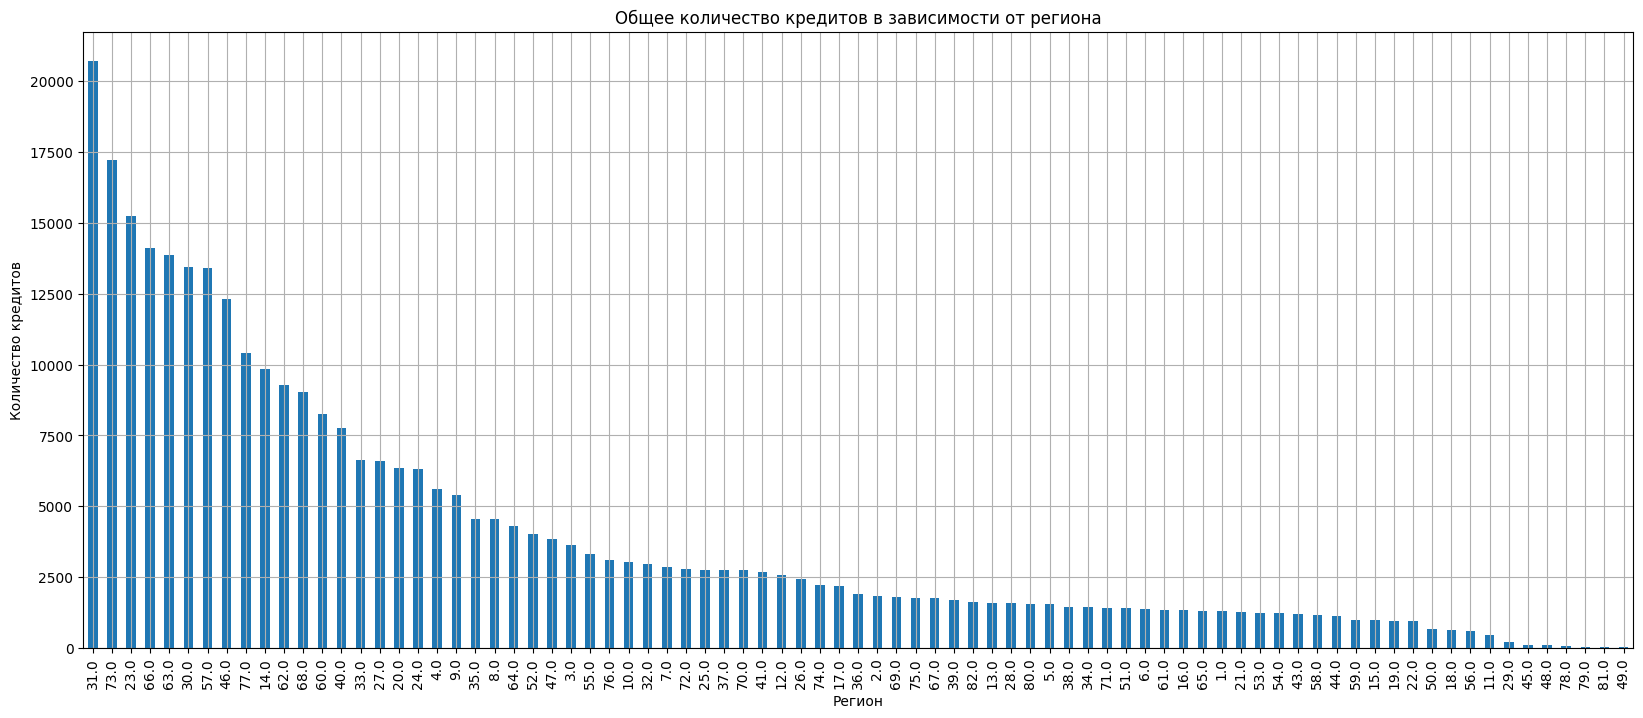

In [130]:
sum_credit_region.plot(x = 'living_region', y = 'credit_count', kind = 'bar',\
figsize=(20,8), grid=True, title = 'Общее количество кредитов в зависимости от региона')
plt.xlabel('Регион')
plt.ylabel('Количество кредитов')
plt.show()

- В 31 регионе больше всего кредитов

**Работа с непрерывными признаками**

Построим ящики с усами и гистограммы для непрерывных признаков

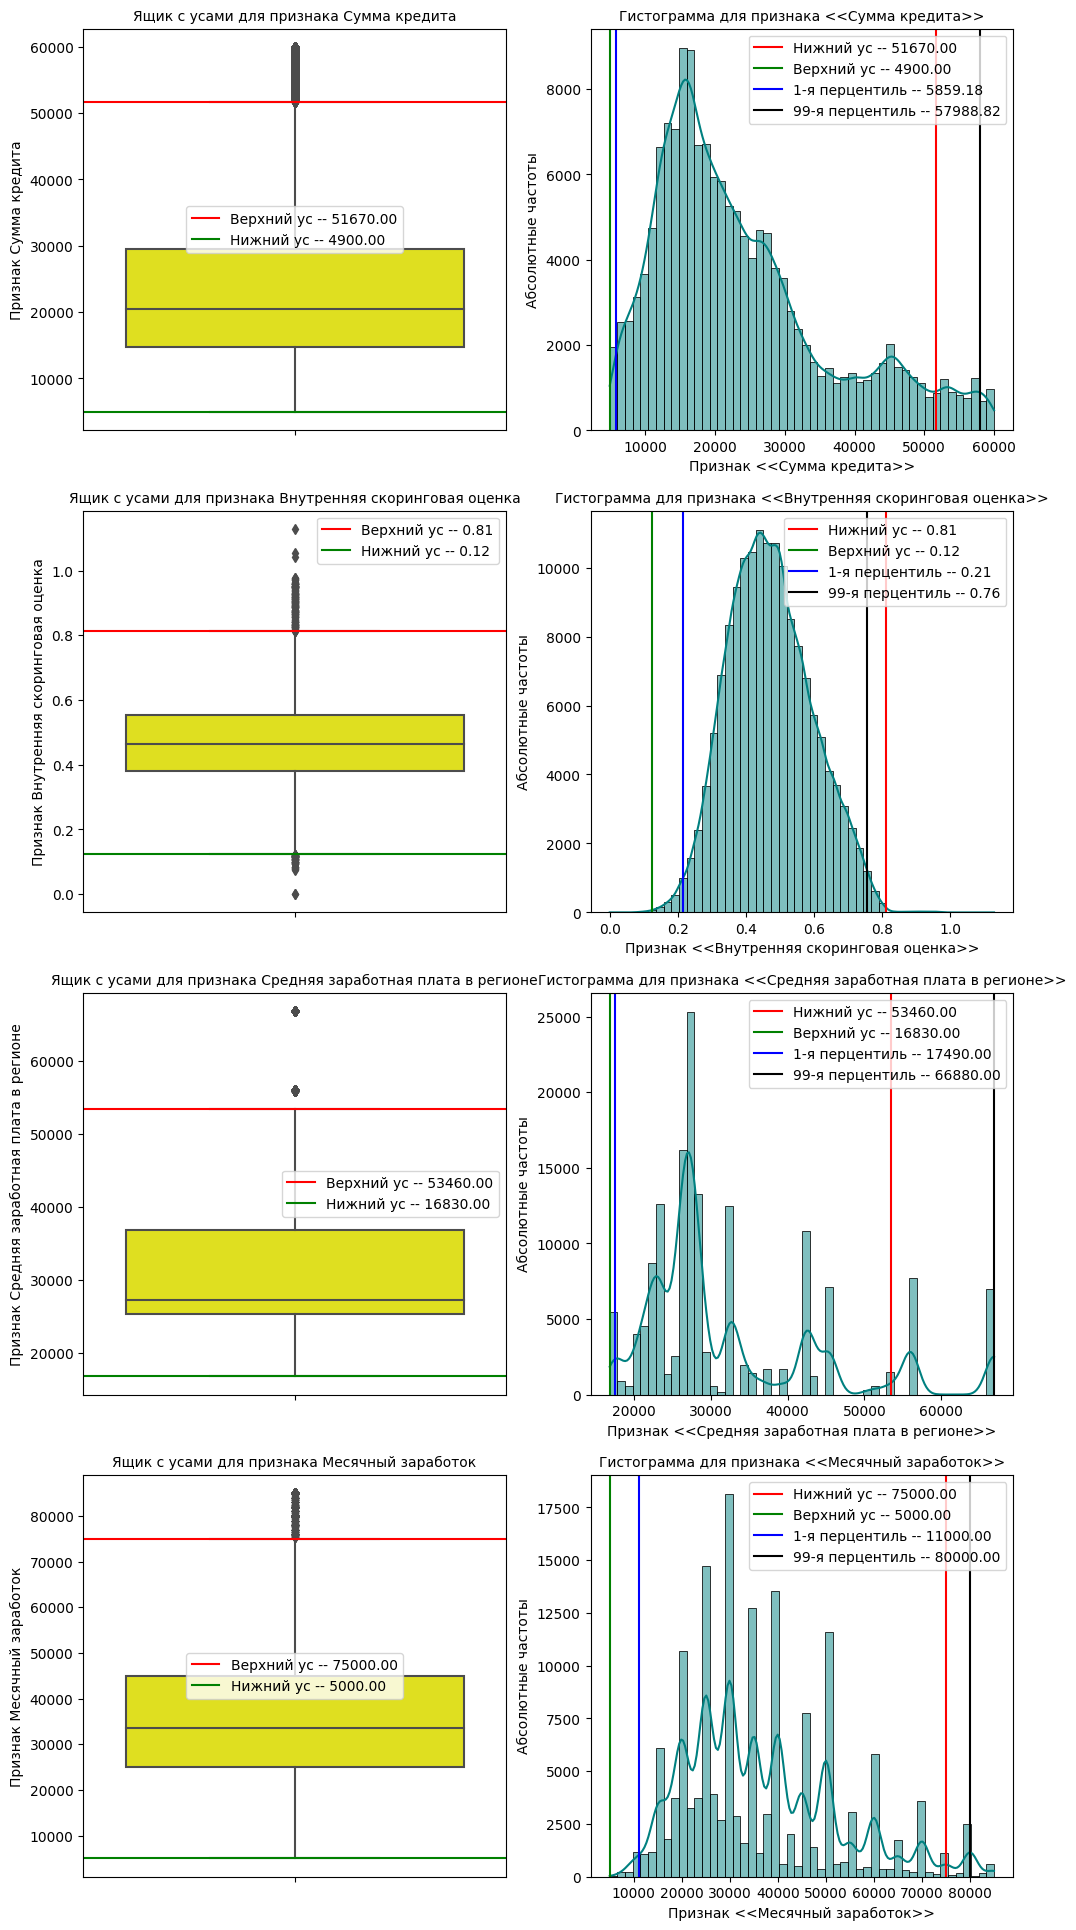

In [131]:
plt.subplots(nrows=4,
             ncols=2,
             #sharey=True,
             figsize=(12,24))
for index, col in enumerate(nepr_vars, start=0):
    plt.subplot(4,2,2*index+1)
    sns.boxplot(data=df,
            y=col,
            color='yellow')
    actual_loval, actual_hival = calc_boxplot(df[col])
    plt.axhline(actual_hival,
            color='red',
            label=f'Верхний ус -- {actual_hival:.2f}')
    plt.axhline(actual_loval,
            color='green',
            label=f'Нижний ус -- {actual_loval:.2f}')
    plt.title(f"Ящик с усами для признака {dict_to_rus.get(col)}", fontsize=10)
    plt.ylabel(f'Признак {dict_to_rus.get(col)}', fontsize=10)
    plt.legend()
    plt.subplot(4,2,2*index+2)
    sns.histplot(data=df,
             x=col,
             color='teal',
             bins=50,
             kde=True)
    plt.title(f'Гистограмма для признака <<{dict_to_rus.get(col)}>>', fontsize=10)
    plt.xlabel(f'Признак <<{dict_to_rus.get(col)}>>', fontsize=10)
    plt.ylabel('Абсолютные частоты', fontsize=10)
    plt.axvline(actual_hival,
                color='red',
                label=f'Нижний ус -- {actual_hival:.2f}')
    plt.axvline(actual_loval,
                color='green',
                label=f'Верхний ус -- {actual_loval:.2f}')
    per_1 = np.nanpercentile(df[col], 1)
    per_99 = np.nanpercentile(df[col], 99)
    plt.axvline(per_1,
                color='blue',
                label=f'1-я перцентиль -- {per_1:.2f}')
    plt.axvline(per_99,
                color='black',
                label=f'99-я перцентиль -- {per_99:.2f}')
    plt.legend();

### Исследовать возможные зависимости между признаками
___


Вычислим корреляцию между признаком возраст и всеми другими столбцами

In [132]:
df.corr()['age'].sort_values()

score_shk              -0.171158
marital_status         -0.137858
gender                 -0.127616
tariff_id              -0.115329
credit_sum             -0.113574
job_position           -0.100648
open_account_flg       -0.040647
monthly_income         -0.034078
avg_zarplata           -0.013157
okrug                  -0.006737
date_bank              -0.003974
year                   -0.003813
month                  -0.001726
user_id                 0.000081
living_region           0.003483
credit_month            0.006572
overdue_credit_count    0.020811
education               0.031224
credit_count            0.124679
age                     1.000000
Name: age, dtype: float64

Вычислим корреляцию между признаком пол и всеми другими столбцами

In [133]:
df.corr()['gender'].sort_values()


age                    -0.127616
credit_count           -0.021271
job_position           -0.013683
score_shk              -0.006557
overdue_credit_count   -0.001241
living_region          -0.000463
credit_month            0.001751
user_id                 0.001892
year                    0.002335
month                   0.002413
date_bank               0.002604
okrug                   0.011727
tariff_id               0.015391
credit_sum              0.018502
avg_zarplata            0.023736
marital_status          0.030549
open_account_flg        0.047331
education               0.085695
monthly_income          0.253615
gender                  1.000000
Name: gender, dtype: float64

Вычислим корреляцию между признаком месячный заработок и всеми другими столбцами

In [134]:
df.corr()['monthly_income'].sort_values()


education              -0.182355
score_shk              -0.099471
job_position           -0.035244
age                    -0.034078
marital_status         -0.030185
open_account_flg       -0.015459
credit_month           -0.007057
user_id                 0.001953
year                    0.002784
date_bank               0.003315
month                   0.003914
living_region           0.004615
tariff_id               0.017139
okrug                   0.036401
overdue_credit_count    0.036944
credit_count            0.143303
gender                  0.253615
credit_sum              0.301786
avg_zarplata            0.367900
monthly_income          1.000000
Name: monthly_income, dtype: float64

Вычислим корреляцию между признаком факт открытия кредитной карты и всеми другими столбцами

In [135]:
df.corr()['open_account_flg'].sort_values()


credit_sum             -0.064431
age                    -0.040647
tariff_id              -0.033301
job_position           -0.031014
monthly_income         -0.015459
living_region          -0.013141
month                   0.000394
user_id                 0.000527
date_bank               0.002322
year                    0.002331
overdue_credit_count    0.014980
avg_zarplata            0.024636
okrug                   0.030733
credit_month            0.031539
credit_count            0.032676
marital_status          0.037435
gender                  0.047331
score_shk               0.048494
education               0.074584
open_account_flg        1.000000
Name: open_account_flg, dtype: float64

Построим матрицу корреляции

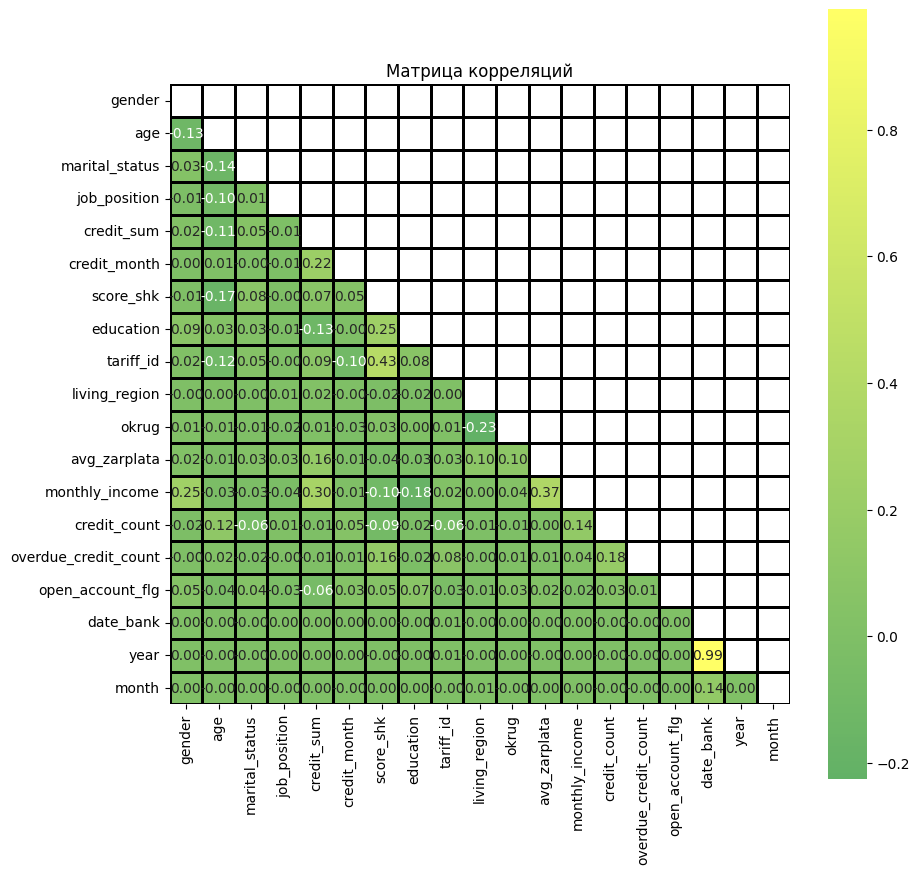

In [136]:
df_n = df.drop(['user_id'], axis=1)
matrix = df_n.corr()

matrix = df_n.corr()

mask = np.triu(np.ones_like(matrix, dtype=bool))

cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

plt.figure(figsize=(10, 10))

sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap='summer', linewidths=1,
                 linecolor='black')
plt.title('Матрица корреляций')
plt.show();

Выглядит так, что по целевому признаку нет корреляции в данных

Наибольшие корреляции:

- monthly_income - credit_sum
- tariff_id - score_shk
- avg_zarplata - monthly_income




Посчитаем общее количество видов образования в зависимости от семейного статуса


In [137]:
df.groupby('marital_status')['education'].sum().sort_values(ascending=False)

marital_status
3    270001
4    156732
2     49989
1     12866
5     10371
Name: education, dtype: int64

Общее количество месячных заработков в зависимости от пола


In [138]:
df.groupby('gender')['monthly_income'].sum().sort_values(ascending=False)

gender
2    2.955659e+09
1    2.638079e+09
Name: monthly_income, dtype: float64

Общее количество месячных заработков в зависимости от суммы кредита


In [139]:
df.groupby('credit_sum')['monthly_income'].sum().sort_values(ascending=False)

credit_sum
53189.00    23434204.0
22990.00    22636436.0
57789.00    19309930.0
39990.00    18512702.0
23990.00    15134420.0
               ...    
15751.00        7000.0
5368.00         7000.0
6359.57         6500.0
12915.00        6000.0
9928.41         6000.0
Name: monthly_income, Length: 37634, dtype: float64

Общее количество баллов в зависимости от тарифов


In [140]:
df.groupby('tariff_id')['score_shk'].sum().sort_values(ascending=False)


tariff_id
2     26507.713974
28    20825.693284
19     6260.354331
20     4523.236692
25     3002.323653
22     2357.146248
30     2007.924170
18     1339.075811
3      1185.708721
23      914.077204
1       767.645958
6       751.608876
29      490.426459
8       275.431189
4       269.833636
9       211.690455
7       193.110410
32      172.963127
31      133.790207
11      128.355075
10      125.902159
12      114.108767
21       52.238117
13       19.698551
14        4.857176
16        3.230506
5         3.095158
26        2.834838
15        2.703271
24        1.911215
27        0.714686
17        0.544100
33        0.337925
Name: score_shk, dtype: float64

**Шаг 4.** Отбор признаков и портреты клиентов:
- исследовать признаки в разрезе групп;
- выявить наличие значимых различий в значениям признаков в разрезе групп;
- сформулировать и проверить гипотезы о равенстве значений показателей по группам

### Исследовать признаки в разрезе групп
____

Создаем две группы: 
1. С открытым кредитным счетом 
2. Без кредитного счета


In [141]:
df_open = df.loc[((df['open_account_flg'] == 1))]
df_no = df.loc[((df['open_account_flg'] == 0))]

Посмотрим описательную статистику в группах

In [142]:
df_open.describe(per)

user_id        gender           age  marital_status  \
count   27247.000000  27247.000000  27247.000000    27247.000000   
mean    85512.505780      1.524315     35.339487        3.256726   
min        18.000000      1.000000     18.000000        1.000000   
1%       1651.840000      1.000000     20.000000        1.000000   
5%       8220.500000      1.000000     21.000000        2.000000   
25%     43007.500000      1.000000     27.000000        3.000000   
50%     85556.000000      2.000000     33.000000        3.000000   
75%    128043.500000      2.000000     42.000000        4.000000   
95%    162332.700000      2.000000     57.000000        4.000000   
99%    169157.540000      2.000000     63.000000        5.000000   
max    170729.000000      2.000000     65.000000        5.000000   
std     49274.688826      0.499418     10.982950        0.781569   

       job_position    credit_sum  credit_month     score_shk     education  \
count  27247.000000  27247.000000  27247.000000  27247.000000  27247.000000   
mean      13.066429  21973.128853     11.186883      0.484019      3.411825   
min        1.000000   4910.000000      3.000000      0.074979      1.000000   
1%         1.000000   5483.417400      3.000000      0.216088      2.000000   
5%         2.000000   7139.000000      6.000000      0.293382      2.000000   
25%       14.000000  13919.000000     10.000000      0.395841      2.000000   
50%       14.000000  19418.000000     10.000000      0.473971      4.000000   
75%       14.000000  27337.750000     12.000000      0.563478      4.000000   
95%       15.000000  46860.659000     18.000000      0.713660      5.000000   
99%       15.000000  56869.620000     24.000000      0.775273      5.000000   
max       18.000000  60000.000000     36.000000      1.054699      5.000000   
std        3.226037  11583.568812      3.875676      0.126327      1.005160   

          tariff_id  living_region         okrug  avg_zarplata  \
count  27247.000000   27247.000000  27247.000000  27247.000000   
mean      13.332807      42.440709      4.946600  32939.227071   
min        1.000000       1.000000      1.000000  16830.000000   
1%         2.000000       3.000000      1.000000  17490.000000   
5%         2.000000       7.000000      2.000000  18920.000000   
25%        2.000000      24.000000      3.000000  25300.000000   
50%       19.000000      39.000000      5.000000  27390.000000   
75%       22.000000      63.000000      7.000000  42460.000000   
95%       28.000000      76.000000      8.000000  66880.000000   
99%       30.000000      80.000000      8.000000  66880.000000   
max       32.000000      82.000000      8.000000  66880.000000   
std       10.870299      22.399653      2.245235  12849.064413   

       monthly_income  credit_count  overdue_credit_count  open_account_flg  \
count    27247.000000  27247.000000           27247.00000           27247.0   
mean     35744.820127      2.194994               0.04984               1.0   
min       5000.000000      0.000000               0.00000               1.0   
1%       10000.000000      0.000000               0.00000               1.0   
5%       15000.000000      0.000000               0.00000               1.0   
25%      25000.000000      1.000000               0.00000               1.0   
50%      32000.000000      2.000000               0.00000               1.0   
75%      45000.000000      3.000000               0.00000               1.0   
95%      70000.000000      6.000000               0.00000               1.0   
99%      80000.000000      8.000000               1.00000               1.0   
max      85000.000000     18.000000               3.00000               1.0   
std      15649.928050      1.759268               0.22080               0.0   

                           date_bank          year         month  
count                          27247  27247.000000  27247.000000  
mean   2018-07-05 19:53:51.266231040   2018.011267      6.496055  
min         

In [143]:
df_no.describe(per)

user_id         gender            age  marital_status  \
count  126972.000000  126972.000000  126972.000000   126972.000000   
mean    85444.384392       1.462354      36.435482        3.184214   
min         1.000000       1.000000      18.000000        1.000000   
1%       1729.710000       1.000000      21.000000        1.000000   
5%       8597.100000       1.000000      23.000000        2.000000   
25%     42704.750000       1.000000      28.000000        3.000000   
50%     85525.500000       1.000000      35.000000        3.000000   
75%    128178.500000       2.000000      43.000000        4.000000   
95%    162191.450000       2.000000      56.000000        4.000000   
99%    169045.290000       2.000000      62.000000        5.000000   
max    170746.000000       2.000000      65.000000        5.000000   
std     49310.610134       0.498583      10.117162        0.728620   

        job_position     credit_sum   credit_month      score_shk  \
count  126972.000000  126972.000000  126972.000000  126972.000000   
mean       13.308288   24100.057433      10.905711       0.468310   
min         1.000000    4900.000000       3.000000       0.000000   
1%          1.000000    5990.000000       4.000000       0.214209   
5%          4.000000    8877.780000       6.000000       0.279786   
25%        14.000000   14798.000000      10.000000       0.378471   
50%        14.000000   20691.000000      10.000000       0.460596   
75%        14.000000   29950.500000      12.000000       0.551661   
95%        15.000000   51568.000000      16.000000       0.686446   
99%        15.000000   58189.000000      24.000000       0.751254   
max        18.000000   60000.000000      36.000000       1.128291   
std         2.915704   12764.652827       3.287117       0.122767   

           education      tariff_id  living_region          okrug  \
count  126972.000000  126972.000000  126972.000000  126972.000000   
mean        3.205407      14.337531      43.211149       4.764554   
min         1.000000       1.000000       1.000000       1.000000   
1%          2.000000       1.000000       3.000000       1.000000   
5%          2.000000       2.000000       7.000000       2.000000   
25%         2.000000       2.000000      25.000000       2.000000   
50%         4.000000      19.000000      41.000000       5.000000   
75%         4.000000      28.000000      63.000000       7.000000   
95%         5.000000      28.000000      76.000000       8.000000   
99%         5.000000      30.000000      80.000000       8.000000   
max         5.000000      33.000000      82.000000       8.000000   
std         1.062513      11.631656      22.349292       2.260870   

        avg_zarplata  monthly_income   credit_count  overdue_credit_count  \
count  126972.000000   126972.000000  126972.000000         126972.000000   
mean    32159.370806    36384.392173       2.048806              0.041781   
min     16830.000000     5600.000000       0.000000              0.000000   
1%      17490.000000    11000.000000       0.000000              0.000000   
5%      20130.000000    15000.000000       0.000000              0.000000   
25%     25300.000000    25000.000000       1.000000              0.000000   
50%     27280.000000    34000.000000       2.000000              0.000000   
75%     36850.000000    45000.000000       3.000000              0.000000   
95%     56000.000000    70000.000000       5.000000              0.000000   
99%     66880.000000    80000.000000       7.000000              1.000000   
max     66880.000000    85000.000000      19.000000              3.000000   
std     11895.894892    15804.468715       1.693637              0.201657   

       open_account_flg                      date_bank           year  \
count          126972.0                         126972  126972.000000   
mean                0.0  2018-07-01 08:10:40.684347648    2017.999063   
min                 0.0            2015-01-01 10:36:12    2015.000000   
1%          

Посмотрим средние значения в группах

In [144]:
df_no.mean()

user_id                                  85444.384392
gender                                       1.462354
age                                         36.435482
marital_status                               3.184214
job_position                                13.308288
credit_sum                               24100.057433
credit_month                                10.905711
score_shk                                     0.46831
education                                    3.205407
tariff_id                                   14.337531
living_region                               43.211149
okrug                                        4.764554
avg_zarplata                             32159.370806
monthly_income                           36384.392173
credit_count                                 2.048806
overdue_credit_count                         0.041781
open_account_flg                                  0.0
date_bank               2018-07-01 08:10:40.684347648
year                        

In [145]:
df_open.mean()

user_id                                   85512.50578
gender                                       1.524315
age                                         35.339487
marital_status                               3.256726
job_position                                13.066429
credit_sum                               21973.128853
credit_month                                11.186883
score_shk                                    0.484019
education                                    3.411825
tariff_id                                   13.332807
living_region                               42.440709
okrug                                          4.9466
avg_zarplata                             32939.227071
monthly_income                           35744.820127
credit_count                                 2.194994
overdue_credit_count                          0.04984
open_account_flg                                  1.0
date_bank               2018-07-05 19:53:51.266231040
year                        

Проверяем моду для категориальных признаков для группы c кредитным счетом

In [146]:
for i in cat_vars:
    print(i, df[df.open_account_flg == 1][i].mode().iloc[0])

age 29
gender 2
marital_status 3
job_position 14
credit_month 10
education 4
tariff_id 2
living_region 31.0
okrug 7.0
credit_count 2.0
overdue_credit_count 0.0
open_account_flg 1
year 2020
month 9


Проверяем моду для категориальных признаков для группы без открытого кредитного счета

In [147]:
for i in cat_vars:
    print(i, df[df.open_account_flg == 0][i].mode().iloc[0])

age 28
gender 1
marital_status 3
job_position 14
credit_month 10
education 4
tariff_id 2
living_region 31.0
okrug 2.0
credit_count 1.0
overdue_credit_count 0.0
open_account_flg 0
year 2018
month 1


Проверим выборки. Одни и те же пользователи не состоят в разных группах


In [148]:
A = set(df_open.user_id)
B = set(df_no.user_id)
A.intersection(B)
A_clear = A - (A.intersection(B))
B_clear = B - (A.intersection(B))
df_open.user_id.isin([A_clear.union(B_clear)]).unique()


array([False])

- выявить наличие значимых различий в значениям признаков в разрезе групп;


Построим графики плотностей и гистограммы исследуемых признаков --- чтобы иметь представление о форме: схожесть с нормальным распределением


Визуально нормальное только у score_shk


/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/3747180234.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, index)
/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/3747180234.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, index)
/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/3747180234.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, index)
/var/folders/71/1jxm86j13ts3fq5rkgv5qy4w0000gn/T/ipykernel_44882/3747180234.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecate

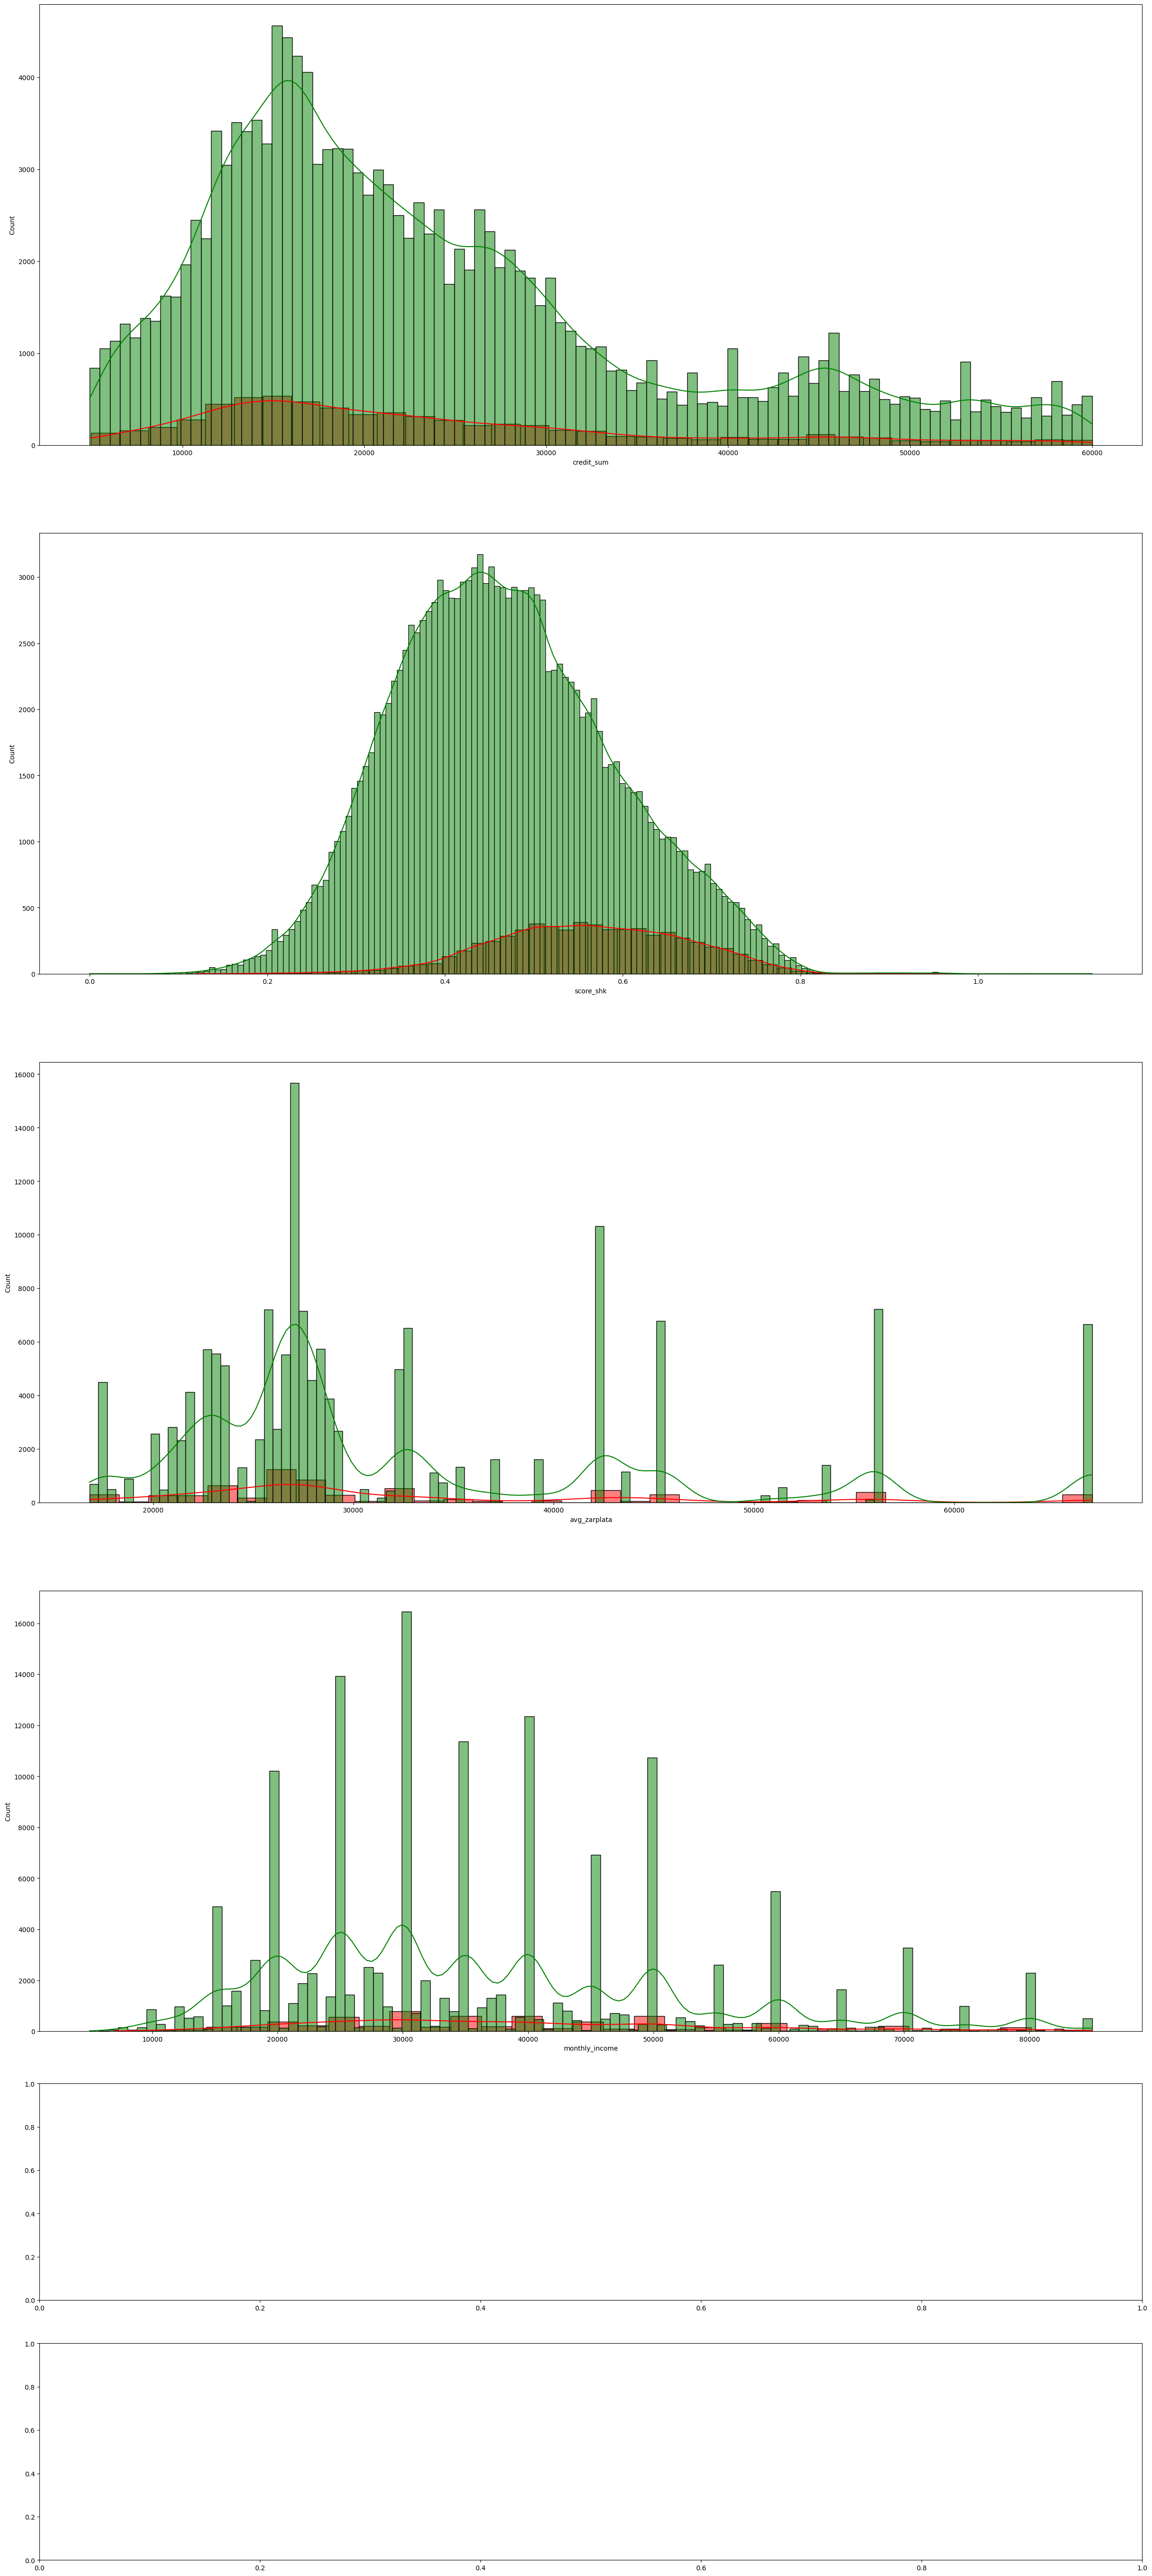

In [149]:

fig, ax = plt.subplots(10, figsize = (30,70))

for index, col in enumerate(nepr_vars, start = 1):
    plt.subplot(5, 1, index)
    sns.histplot(df[df.overdue_credit_count == 1][col].dropna(), kde = True, color = 'red')
    sns.histplot(df[df.overdue_credit_count == 0][col].dropna(), kde = True, color = 'green');

**После исследования признаков, проверим гипотезы**

H_0: Выборки data_1 и data_2 подчиняются одному закону распределения


H_1: Выборки data_1 и data_2 не подчиняются одному закону распределения

Если $p_{value} \leqslant \alpha$, то гипотеза $H_0$ отвергается на уровне значимости $\alpha$ и принимается гипотеза $H_1$. В противном случае нет оснований отвегать гипотезу $H_0$.

Убираем ненужные столбцы


In [150]:
df_ks = df.drop(['user_id', 'date_bank', 'open_account_flg'], axis=1)

Проверка с помощью критерия Колмогорова-Смирнова

In [151]:
ks_test(df_ks)

Kolmogorov-Smirnov test for column gender: KS Statistic = 0.003103281882895992, p-value = 0.9999999805284024
H_0: Обе выборки подчиняются из одному и тому же распределению.
------------------------------------------------------------
Kolmogorov-Smirnov test for column age: KS Statistic = 0.08449437006497776, p-value = 1.9288062203979234e-39
H_1: Обе выборки происходят из разных распределений.
------------------------------------------------------------
Kolmogorov-Smirnov test for column marital_status: KS Statistic = 0.06466402191878673, p-value = 2.8872351529259377e-23
H_1: Обе выборки происходят из разных распределений.
------------------------------------------------------------
Kolmogorov-Smirnov test for column job_position: KS Statistic = 0.017661729673064896, p-value = 0.0393426597332609
H_1: Обе выборки происходят из разных распределений.
------------------------------------------------------------
Kolmogorov-Smirnov test for column credit_sum: KS Statistic = 0.0315049439735953

Проверим на нормальность выборки, которые подчиняются одному распределению

H_0: Случайная величина gender подчиняется нормальному закону распределения


H_1: Случайная величина gender имеет распределение, отличное от нормального закона

Если $p_{value} \leqslant \alpha$, то гипотеза $H_0$ отвергается на уровне значимости $\alpha$ и принимается гипотеза $H_1$. В противном случае нет оснований отвегать гипотезу $H_0$.

In [152]:
print(shapiro(df[df.overdue_credit_count == 1].gender.dropna()))
print(shapiro(df[df.overdue_credit_count == 0].gender.dropna()))

ShapiroResult(statistic=0.6353839039802551, pvalue=0.0)
ShapiroResult(statistic=0.6352089643478394, pvalue=0.0)


/Users/elmypka/Library/Python/3.9/lib/python/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


**Гипотеза H_0 отвергается**


**Гипотеза H_0 отвергается**

H_0: Случайная величина year подчиняется нормальному закону распределения


H_1: Случайная величина year имеет распределение, отличное от нормального закона

Если $p_{value} \leqslant \alpha$, то гипотеза $H_0$ отвергается на уровне значимости $\alpha$ и принимается гипотеза $H_1$. В противном случае нет оснований отвегать гипотезу $H_0$.

In [154]:
print(shapiro(df[df.overdue_credit_count == 1].year.dropna()))
print(shapiro(df[df.overdue_credit_count == 0].year.dropna()))


ShapiroResult(statistic=0.9198843836784363, pvalue=0.0)
ShapiroResult(statistic=0.9178227782249451, pvalue=0.0)


**Гипотеза H_0 отвергается**


**Гипотеза H_0 отвергается**

H_0: Случайная величина month подчиняется нормальному закону распределения


H_1: Случайная величина month имеет распределение, отличное от нормального закона

Если $p_{value} \leqslant \alpha$, то гипотеза $H_0$ отвергается на уровне значимости $\alpha$ и принимается гипотеза $H_1$. В противном случае нет оснований отвегать гипотезу $H_0$.

In [156]:
print(shapiro(df[df.overdue_credit_count == 1].month.dropna()))
print(shapiro(df[df.overdue_credit_count == 0].month.dropna()))

ShapiroResult(statistic=0.9428985118865967, pvalue=1.1210387714598537e-44)
ShapiroResult(statistic=0.9406079649925232, pvalue=0.0)


**Гипотеза H_0 отвергается**


**Гипотеза H_0 отвергается**

Убираем столбцы 'user_id', 'date_bank' - есть более показательный критерий - год и месяц

In [157]:
df_1 = df.drop(['user_id', 'date_bank', 'open_account_flg'], axis=1)

**Проверяем значимость по U-критерию Манна — Уитни**

In [158]:
mann_whitney_test(df_1)

Mann-Whitney U test for column gender: U Statistic = 482440853.0, p-value = 0.6223835760273311
Нулевая гипотеза (отсутствует различие в распределении частот) не может быть отклонена.                       H_0 - Разница в признаке gender статистически не значима.
Среднее значение признака gender: 1 - у людей с картой 1.4703370443800519 ||| 2 - у людей без карты 1.4734403262629479
------------------------------------------------------------
Mann-Whitney U test for column age: U Statistic = 521169097.5, p-value = 4.46660923855195e-26
Нулевая гипотеза (отсутствует различие в распределении частот) отклонена.                      H_1 - Разница в признаке age статистически значима.
Среднее значение признака age: 1 - у людей с картой 37.24904682019216 ||| 2 - у людей без карты 36.19646232326859
------------------------------------------------------------
Mann-Whitney U test for column marital_status: U Statistic = 452647541.0, p-value = 4.79534100717232e-23
Нулевая гипотеза (отсутствует различ

**Портреты клиентов**

Можно предположить, что клиенты, склонные к открытию карты обладают сдедующими показателями:

- Возраст более 37 лет
- Внутренняя скоринговая оценка более 0.5
- Месячный заработков более 39000
- Количеством кредитов более 3


Можно предположить, что клиенты, не склонные к открытию карты обладают сдедующими показателями:
- Возраст менее 36 лет
- Внутренняя скоринговая оценка менее 0.4
- Месячный заработков менее 36000
- Количеством кредитов менее 2


**Шаг 5.** Построить классификационные модели 
- Построить несколько моделей классификации и сравнить их.    
- исследовать возможные зависимости между признаками;

Т.к. в данном датафрейме количество клиетов, склонных к открытию карты значительно меньше, то для работающих методов классификации продублируем в дф данные клиентов с открытой картой

In [159]:
df_2 = pd.concat([df, df_open], ignore_index= True )
df_2 = pd.concat([df_2, df_open], ignore_index= True )
df_2 = pd.concat([df_2, df_open], ignore_index= True )

Формирование признакового пространства


In [160]:
df.columns

Index(['user_id', 'gender', 'age', 'marital_status', 'job_position',
       'credit_sum', 'credit_month', 'score_shk', 'education', 'tariff_id',
       'living_region', 'okrug', 'avg_zarplata', 'monthly_income',
       'credit_count', 'overdue_credit_count', 'open_account_flg', 'date_bank',
       'year', 'month'],
      dtype='object')

In [183]:
select_columns = ['gender', 
                  'score_shk',
                  'age', 
                  'marital_status', 
                  'job_position',
                  'credit_sum',
                  'monthly_income',
                  'credit_count'
                  ]
y = df_2.open_account_flg
x = df_2[select_columns]

Разделение на обучающее и тестирующее множества


In [184]:
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                    test_size=0.3,
                                                    random_state=0)

In [185]:
x_train

gender  score_shk  age  marital_status  job_position  credit_sum  \
80236        2   0.445345   24               4            14    21799.00   
230377       2   0.264843   34               3            15    26744.44   
52376        2   0.536058   25               4            14    31753.00   
132363       1   0.496858   30               4            15    24270.00   
235003       1   0.496356   60               4            14    16926.00   
...        ...        ...  ...             ...           ...         ...   
176963       1   0.577175   40               2            14     9901.00   
117952       2   0.392949   53               4            14    14919.00   
173685       2   0.620913   30               4            15    34159.00   
43567        2   0.423171   29               3            15    19818.00   
199340       2   0.429892   29               3            14    25551.00   

        monthly_income  credit_count  
80236          50000.0           2.0  
230377         70000.0           1.0  
52376          25000.0           1.0  
132363         40000.0           6.0  
235003         21000.0           4.0  
...                ...           ...  
176963         20000.0           4.0  
117952         35000.0           1.0  
173685         35000.0           0.0  
43567          35000.0           3.0  
199340         42000.0           1.0  

[165172 rows x 8 columns]

Проведет нормализацию обучающего и тестового множеств независимых переменных и определим параметры от которых зависит скалер



In [186]:
st_scaler = MinMaxScaler()

st_scaler.fit(x_train)

MinMaxScaler()

Проверка работы


In [187]:
x_train.age.mean()

35.93811905165524

Преобразование независимых переменных

In [188]:
x_train_st = st_scaler.transform(x_train)
x_test_st = st_scaler.transform(x_test)

Поиск параметров для логистической регресси по сетке


In [191]:
grid_searcher = GridSearchCV(
    LogisticRegression(max_iter=3000, random_state=42, solver = 'saga'),
    param_grid={
        'C': [0.01, 0.1, 0.5, 1, 10, 50],
        'penalty' : ['l1', 'l2']
    },
    cv=5,
    scoring='precision'
)
grid_searcher.fit(x_train_st, y_train);
print ('best_score -- {}'.format(grid_searcher.best_score_))
print ('best_params -- {}'.format(grid_searcher.best_params_))

best_score -- 0.5573474663205435
best_params -- {'C': 0.01, 'penalty': 'l2'}


Строим модель классификации Logistic Regression (LR) - логистическая регрессия;


In [194]:
lr = LogisticRegression(C=0.01, penalty='l2',solver='saga')
lr.fit(x_train_st, y_train)
lr.coef_
y_pred = lr.predict(x_test_st)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65     38183
           1       0.55      0.37      0.45     32605

    accuracy                           0.57     70788
   macro avg       0.57      0.56      0.55     70788
weighted avg       0.57      0.57      0.56     70788



In [195]:
#В неочищенных данных выходит 0.80


Поиск параметров для случайного леса

In [196]:
grid_searcher = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        'n_estimators': [1, 50, 100, 150, 200],
        'max_depth' : [1, 2, 3, 4, 5, 6]
    },
    cv=5,
    scoring='accuracy')

grid_searcher.fit(x_train_st, y_train);
print ('best_score -- {}'.format(grid_searcher.best_score_))
print ('best_params -- {}'.format(grid_searcher.best_params_))

best_score -- 0.60590777920706
best_params -- {'max_depth': 6, 'n_estimators': 50}


Строим модель классификации  Random Forest Classifier (RF) - случайный лес (используются деревья решений);

In [197]:
rnd = RandomForestClassifier(max_depth=6, n_estimators=50, random_state=0)
rnd.fit(x_train_st, y_train)
rnd.feature_importances_
# rnd.score(x_test_st, y_test)
y_pred = rnd.predict(x_test_st)
print('Отчет о классификации', '\n', classification_report(y_test, y_pred))

Отчет о классификации 
               precision    recall  f1-score   support

           0       0.60      0.84      0.70     38183
           1       0.64      0.34      0.44     32605

    accuracy                           0.61     70788
   macro avg       0.62      0.59      0.57     70788
weighted avg       0.62      0.61      0.58     70788



In [198]:
rnd = RandomForestClassifier(random_state=0)
rnd.fit(x_train_st, y_train)
rnd.feature_importances_
# rnd.score(x_test_st, y_test)
y_pred = rnd.predict(x_test_st)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94     38183
           1       0.90      0.98      0.94     32605

    accuracy                           0.94     70788
   macro avg       0.94      0.95      0.94     70788
weighted avg       0.95      0.94      0.94     70788



Без указания дополнительных параметров результат вышел значительно лучше

Строим модель классификации  Support Vector Machines (SVM) - метод опорных векторов


In [199]:
svc = SVC(C = 1,
          degree = 3,
          gamma = 1,
          kernel = 'linear',
          random_state=42)
svc.fit(x_train_st, y_train)
svc.score(x_test_st, y_test)

0.5747019268802622

**Вывод:**


**Модель классификации  Random Forest Classifier (RF) - случайный лес (используются деревья решений) работает лучше, чем остальные**

#### Построить классификационные модели для прогнозирования значений целевой переменной. 

In [200]:
x_train.head(2)

gender  score_shk  age  marital_status  job_position  credit_sum  \
80236        2   0.445345   24               4            14    21799.00   
230377       2   0.264843   34               3            15    26744.44   

        monthly_income  credit_count  
80236          50000.0           2.0  
230377         70000.0           1.0

In [204]:
x_new = np.array([[1, 0.29, 33, 2, 13, 20000, 25000, 2],
                  [2, 0.457, 75, 1, 15, 35000, 40000, 0],
                  [2, 0.67, 18, 3, 7, 15000, 70000, 0]])
x_new_st = st_scaler.transform(x_new)

/Users/elmypka/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [205]:
rnd.predict(x_new)
rnd.predict_proba(x_new)

array([[0.59, 0.41],
       [0.5 , 0.5 ],
       [0.56, 0.44]])

- 1 обьект с вероятностью 59 оформит кредитную карту
- 2 обьект с вероятностью 0.5 оформит кредитную карту
- 3 обьект с вероятностью 56 оформит кредитную карту

**Итоговый вывод:**


Цель данного проекта заключалась в проведении анализ данных для выделения портрета клиентов, которые будут открывать карту, и портрета клиентов, которые не будут открывать карту.



В рамках аналитической задачи по выделению портрета клиентов, была проведена первичная обработка данных, проведен исследовательский анализ данных, отобраны признаки и выявлены портреты клиентов. Далее были построены классификационные модели для прогнозирования значений целевой переменной.

Мы выяснили, что клиенты, склонные к открытию карты обладают сдедующими показателями:

- Возраст более 37 лет
- Внутренняя скоринговая оценка более 0.5
- Месячный заработков более 39000
- Количеством кредитов более 3


Клиенты, не склонные к открытию карты обладают сдедующими показателями:
- Возраст менее 36 лет
- Внутренняя скоринговая оценка менее 0.4
- Месячный заработков менее 36000
- Количеством кредитов менее 2
